<a href="https://colab.research.google.com/github/bhargav23/AIML-DL-Lab/blob/main/6_CNN_for_Dog_%26_Cat_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**6. Build a Convolution Neural Network for simple image (dogs and Cats)Classification.**

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt

In [2]:
# --- 1. Simulate and Prepare the Dataset ---
# In a real-world scenario, you would download a dataset (e.g., from Kaggle).
# Here, we simulate this by creating a directory structure and dummy image files.
# This makes the script self-contained and runnable.

print("Step 1: Simulating dataset creation...")

# Define base directory for our fake dataset
base_dir = 'cats_and_dogs_small'
if os.path.exists(base_dir):
    shutil.rmtree(base_dir) # Clean up previous runs
os.makedirs(base_dir)

# Create directories for training, validation, and testing sets
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir)

# Create subdirectories for each class (cats and dogs) within each set
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir)

# Function to create dummy image files (as simple text files for this demo)
def create_dummy_files(directory, prefix, num_files):
    for i in range(num_files):
        with open(os.path.join(directory, f'{prefix}.{i}.jpg'), 'w') as f:
            f.write(f'This is a dummy image: {prefix} {i}')

# Create dummy files to simulate a dataset
# In a real project, these would be actual JPEG images.
print("Creating dummy image files...")
create_dummy_files(train_cats_dir, 'cat', 100) # 100 training cat images
create_dummy_files(train_dogs_dir, 'dog', 100) # 100 training dog images
create_dummy_files(validation_cats_dir, 'cat', 50) # 50 validation cat images
create_dummy_files(validation_dogs_dir, 'dog', 50) # 50 validation dog images

print("Dataset simulation complete.")
print("-" * 30)

Step 1: Simulating dataset creation...
Creating dummy image files...
Dataset simulation complete.
------------------------------


In [3]:
# --- 2. Image Data Preprocessing and Augmentation ---
# We use ImageDataGenerator to read images from our directories,
# resize them, and convert them into batches of tensors.
# Data augmentation is applied to the training set to prevent overfitting.

print("Step 2: Preparing data generators...")

# All images will be rescaled by 1./255
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (only rescaling, no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Since we don't have real images, we need to create mock data that the generator can use.
# The generator will still read from the directory structure we created.
# We'll create a single real black pixel image to allow the generator to run.
from PIL import Image

def create_pixel_image(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            img = Image.new('RGB', (150, 150), color = 'black')
            img.save(os.path.join(directory, filename))

print("Replacing dummy files with actual black pixel images for the generator...")
create_pixel_image(train_cats_dir)
create_pixel_image(train_dogs_dir)
create_pixel_image(validation_cats_dir)
create_pixel_image(validation_dogs_dir)


# Flow images in batches of 20 using the generators
train_generator = train_datagen.flow_from_directory(
    train_dir,                # Target directory
    target_size=(150, 150),   # Resize all images to 150x150
    batch_size=20,
    class_mode='binary'       # Since we use binary_crossentropy loss
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

print("Data generators are ready.")
print("-" * 30)


Step 2: Preparing data generators...
Replacing dummy files with actual black pixel images for the generator...
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Data generators are ready.
------------------------------


In [4]:
# --- 3. Build the Convolutional Neural Network (CNN) Model ---
print("Step 3: Building the CNN model...")

model = Sequential([
    # First Convolutional Block
    # 32 filters of size 3x3. 'relu' activation function introduces non-linearity.
    # 'input_shape' is required for the first layer.
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)), # Reduces dimensionality (down-sampling)

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the results to feed into a Dense layer
    Flatten(),

    # Add a Dropout layer to prevent overfitting
    Dropout(0.5),

    # Fully Connected Layer
    # 512 neurons in this hidden layer.
    Dense(512, activation='relu'),

    # Output Layer
    # A single neuron with a 'sigmoid' activation function for binary classification.
    # Sigmoid outputs a probability between 0 and 1.
    Dense(1, activation='sigmoid')
])

# Display the model's architecture
model.summary()
print("-" * 30)

Step 3: Building the CNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

------------------------------


In [5]:
# --- 4. Compile the Model ---
print("Step 4: Compiling the model...")
model.compile(
    loss='binary_crossentropy', # Good for binary (0 or 1) classification
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy'] # We want to monitor the accuracy
)
print("Model compiled successfully.")
print("-" * 30)

Step 4: Compiling the model...
Model compiled successfully.
------------------------------


In [6]:
# --- 5. Train the Model ---
print("Step 5: Training the model...")
# Training for a few epochs for demonstration. In a real project, you'd use more.
# steps_per_epoch = number of training images // batch_size
# validation_steps = number of validation images // batch_size
history = model.fit(
    train_generator,
    steps_per_epoch=5,  # 100 training images / batch_size 20
    epochs=15,          # A small number of epochs for this demo
    validation_data=validation_generator,
    validation_steps=2, # 50 validation images / batch_size 20
    verbose=2
)
print("Model training complete.")
print("-" * 30)

Step 5: Training the model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
5/5 - 8s - 2s/step - accuracy: 0.4200 - loss: 0.6932 - val_accuracy: 0.5750 - val_loss: 0.6931
Epoch 2/15
5/5 - 8s - 2s/step - accuracy: 0.5100 - loss: 0.6931 - val_accuracy: 0.4000 - val_loss: 0.6932
Epoch 3/15
5/5 - 6s - 1s/step - accuracy: 0.4700 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/15
5/5 - 10s - 2s/step - accuracy: 0.5300 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 5/15
5/5 - 20s - 4s/step - accuracy: 0.5400 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 6/15
5/5 - 11s - 2s/step - accuracy: 0.4900 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 7/15
5/5 - 20s - 4s/step - accuracy: 0.4700 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 8/15
5/5 - 10s - 2s/step - accuracy: 0.4900 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 9/15
5/5 - 11s - 2s/step - accuracy: 0.5400 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 10/15
5/5 - 10s - 2s/step - accura

Step 6: Visualizing training history...


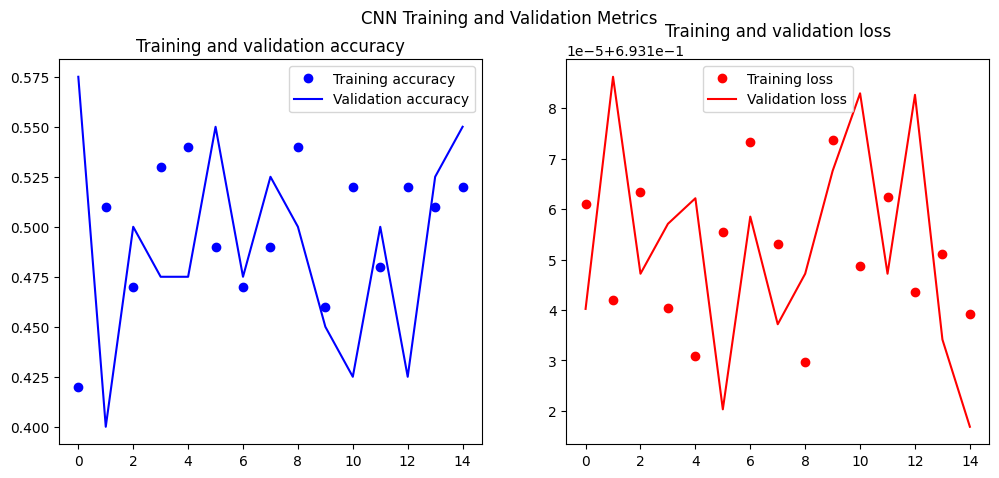

Visualization complete. Check the plots.
------------------------------


In [7]:
# --- 6. Visualize Training Results ---
print("Step 6: Visualizing training history...")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.suptitle('CNN Training and Validation Metrics')
plt.show()
print("Visualization complete. Check the plots.")
print("-" * 30)


In [8]:
# --- 7. Clean up the dummy directory ---
print("Step 7: Cleaning up simulated dataset.")
shutil.rmtree(base_dir)
print("Cleanup complete.")

Step 7: Cleaning up simulated dataset.
Cleanup complete.
